In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import scipy
import tqdm
import numpy as np
import os
import pandas as pd
import random

In [2]:
train_path = "dataset/train"
test_path = "dataset/test"

In [3]:
img_angry = cv2.imread("dataset/train/angry/Training_10118481.jpg")
img_fear = cv2.imread('dataset/train/fear/Training_10018621.jpg')
img_happy = cv2.imread('dataset/train/happy/Training_1206.jpg')
img_sad = cv2.imread('dataset/train/sad/Training_2913.jpg')
img_surprise = cv2.imread('dataset/train/surprise/Training_8796.jpg')

Text(0.5, 1.0, 'Surprise')

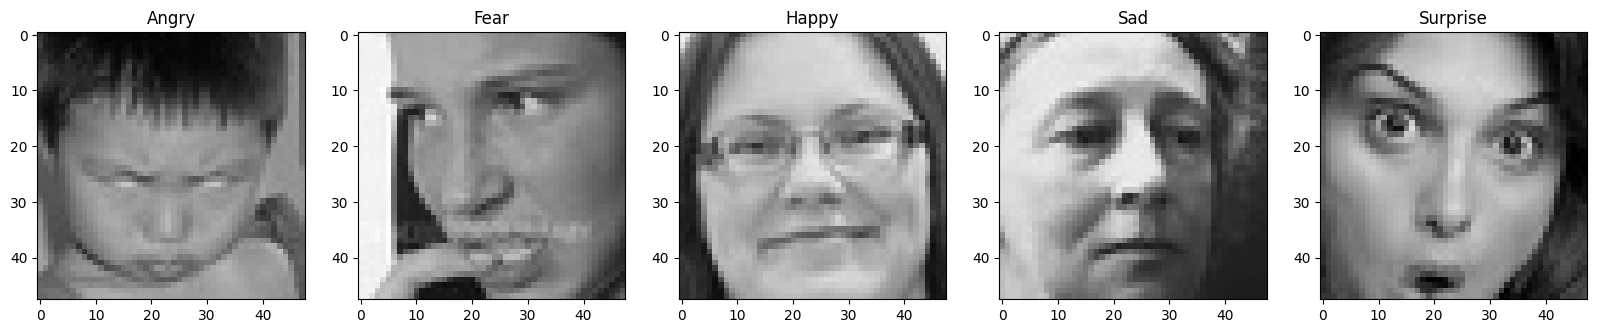

In [4]:
fig, ax = plt.subplots(1,5, figsize=(20,20))
ax[0].imshow(img_angry)
ax[0].set_title('Angry')
ax[1].imshow(img_fear)
ax[1].set_title('Fear')
ax[2].imshow(img_happy)
ax[2].set_title('Happy')
ax[3].imshow(img_sad)
ax[3].set_title('Sad')
ax[4].imshow(img_surprise)
ax[4].set_title('Surprise')

In [5]:
def load_dataset(path):
    image_paths = []
    labels = []
    for label in os.listdir(path):
        for image in os.listdir(path + "/" + label):
            image_paths.append(path + "/" + label + "/" + image)
            labels.append(label)
    return image_paths, labels

def extract_features(images):
    features = []
    for img in tqdm.tqdm(images):
        img = load_img(img, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(features.shape[0], 48, 48, 1)
    return features

train = pd.DataFrame()
train['image_path'], train['label'] = load_dataset(train_path)
test = pd.DataFrame()
test['image_path'], test['label'] = load_dataset(test_path)

In [6]:
train.head()

,image_path,label
0,dataset/train/angry/0.jpg,angry
1,dataset/train/angry/1.jpg,angry
2,dataset/train/angry/10.jpg,angry
3,dataset/train/angry/10002.jpg,angry
4,dataset/train/angry/10005903.png,angry


In [7]:
train_features = extract_features(train['image_path'])
test_features = extract_features(test['image_path'])

100%|██████████| 11215/11215 [00:23<00:00, 472.21it/s]


In [8]:
train_features.shape, test_features.shape

((98779, 48, 48, 1), (11215, 48, 48, 1))

In [9]:
x_train = train_features/255
x_test = test_features/255

In [10]:
# pca = PCA(n_components=2)
# pca.fit(x_train.reshape(x_train.shape[0], 48*48))
# x_train_pca = pca.transform(x_train.reshape(x_train.shape[0], 48*48))
# x_test_pca = pca.transform(x_test.reshape(x_test.shape[0], 48*48))

# x_train_pca.shape, x_test_pca.shape

In [11]:
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
y_train.shape, y_test.shape

((98779, 5), (11215, 5))

In [12]:
classes = 5
input_shape = (48, 48, 1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(classes, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6),
              metrics=['accuracy', 'AUC'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [14]:
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
3087/3087 [==============================] - 40s 12ms/step - loss: 7.2365 - accuracy: 0.3099 - auc: 0.6278 - val_loss: 6.8616 - val_accuracy: 0.3053 - val_auc: 0.6358
Epoch 2/50
3087/3087 [==============================] - 38s 12ms/step - loss: 6.3251 - accuracy: 0.3882 - auc: 0.7121 - val_loss: 6.1124 - val_accuracy: 0.3538 - val_auc: 0.6732
Epoch 3/50
3087/3087 [==============================] - 40s 13ms/step - loss: 5.5144 - accuracy: 0.4365 - auc: 0.7560 - val_loss: 5.3804 - val_accuracy: 0.3987 - val_auc: 0.7143
Epoch 4/50
3087/3087 [==============================] - 40s 13ms/step - loss: 4.8481 - accuracy: 0.4683 - auc: 0.7834 - val_loss: 4.7425 - val_accuracy: 0.4309 - val_auc: 0.7464
Epoch 5/50
3087/3087 [==============================] - 42s 14ms/step - loss: 4.3036 - accuracy: 0.4944 - auc: 0.8036 - val_loss: 4.2237 - val_accuracy: 0.4564 - val_auc: 0.7698
Epoch 6/50
3087/3087 [==============================] - 41s 13ms/step - loss: 3.8565 - accuracy: 0.5169 - auc:

In [15]:
model.save('model.h5')

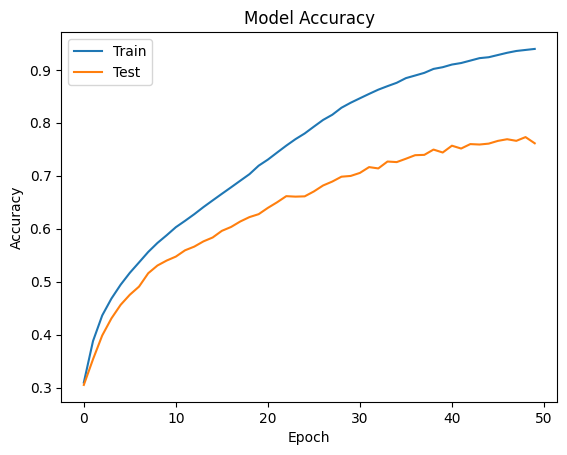

In [16]:
model.history.history.keys()

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Original Output: surprise
1/1 [==============================] - 0s 11ms/step
Predicted Output: surprise


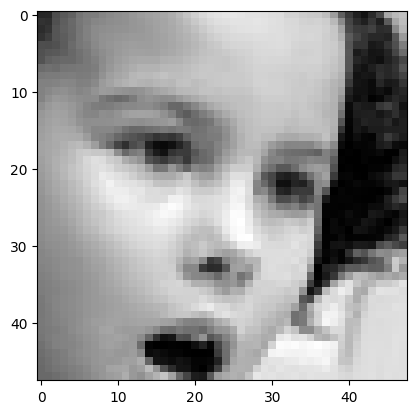

In [44]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');